In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from datasets import load_dataset

In [3]:
from common_utils.eval import EvalClient, EvalRunner
from common_utils.image_utils import show_image

In [4]:
from common_utils.buckets import CategoryEvalRunner

In [5]:
from common_utils.judge import JudgeClient, LLMJudge

#### Generate Different Model Outputs

In [ ]:
@dataclass
class EvalConfig:
    base_url: str = "http://localhost:8010/v1"
    api_key: str = "EMPTY"
    model: str = "Qwen/Qwen2.5-VL-3B-Instruct"
    # model: str = "google/gemma-3-27b-it"
    # model: str = "moonshotai/Kimi-VL-A3B-Thinking-2506"
    # model: str = "Qwen/Qwen2.5-VL-7B-Instruct"
    temperature: float = 0.5
    max_tokens: int = 2048
    
eval_client = EvalConfig()

@dataclass
class JudgeConfig:
    base_url: str = "http://localhost:8000/v1"
    api_key: str = "EMPTY"
    model: str = "google/gemma-3-27b-it"    
    max_retries: int = 3
    backoff: float = 0.6
    max_tokens: int = 2048
    temperature: float = 0.0

judge_client = JudgeConfig()


### Test the Evaluation

In [7]:
# 1) dataset (your existing filtering)
dataset = load_dataset("lmarena-ai/VisionArena-Chat", split="train", streaming=True)
en_dataset = dataset.filter(lambda ex: ex["num_turns"] == 1 and ex["language"] == "English")
LEN_SMALL_DS = 2000
small_ds = en_dataset.take(LEN_SMALL_DS)

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

In [8]:
# 3) wire eval
client = EvalClient(eval_client.base_url, eval_client.api_key)
runner = EvalRunner(eval_client, client)

In [9]:
# C) choose categories & run 10 per
categories = ["ocr", "code", "is_code", "refusal"]  # add/remove as needed
cat_runner = CategoryEvalRunner(runner, k=10, id_key="conversation_id", exclusive=True)

### Test one Sample

In [10]:
import random
import itertools

k = random.randrange(LEN_SMALL_DS/10)
sample = next(itertools.islice(small_ds, k, k+1))


/tmp/ipykernel_112130/4274033265.py:4: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  k = random.randrange(LEN_SMALL_DS/10)


=== Eval Output ===
conv_id: 9b9900c6e4c14158adf64be1671bc506
dataset_model: chatgpt-4o-latest-20240903
user_question: My goodness, what an attractive photograph. That wine looks like particularly dark and lush. Do you know anything of it? ...
reference_answer: Ah, that is indeed a striking photograph, and the wine you're referring to is the **Vatan Toro 2012**. This wine is from ...
model_answer: The photograph showcases a bottle of Vatan Toro 2012 wine. The wine is a red variety, likely a blend of Tempranillo, Garnacha, and other local varieties typical for the Toro region in Spain. The Toro  ...
latency: 1.1327 sec


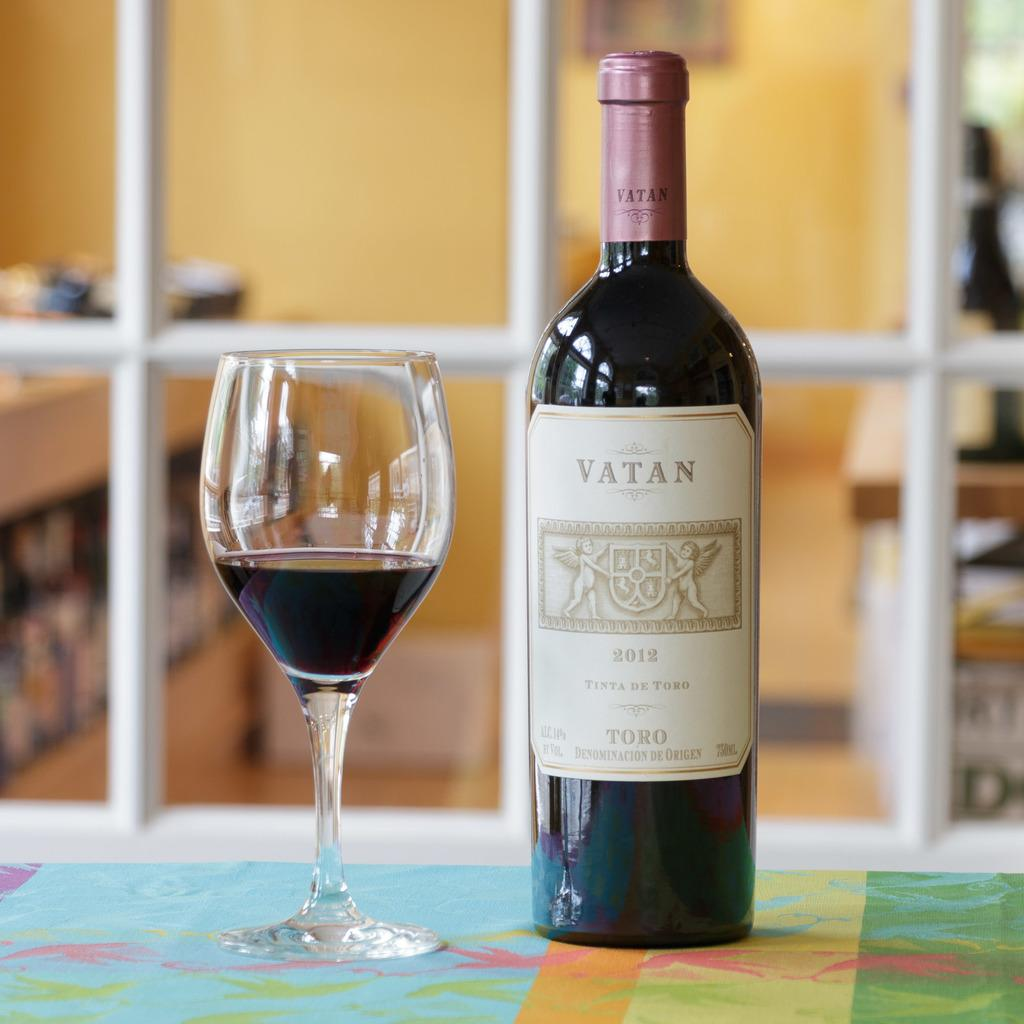

In [26]:
# 4) run eval on the sample
out = runner.run_on_sample(sample)
print("=== Eval Output ===")
print("conv_id:", out.conversation_id)
print("dataset_model:", out.dataset_model)
print("user_question:", out.user_question[:120], "...")
print("reference_answer:", out.reference_answer[:120], "...")
print("model_answer:", out.model_answer[:200], "...")
print("latency:", out.latency_sec, "sec")
show_image(out.images[0].get('bytes'))

### Creating batches

In [12]:
buckets = cat_runner.build_buckets(iter(small_ds), categories)

[BUCKETS] Building buckets...
  - target_categories: ['ocr', 'code', 'is_code', 'refusal']
  - k per category   : 10
  - exclusive        : True
  - id_key           : conversation_id
[BUCKETS] Done in 23.67s
[BUCKETS] Counts:
  - ocr               10/10 ✓
  - code              10/10 ✓
  - is_code           10/10 ✓
  - refusal           10/10 ✓
[BUCKETS] Preview (first few IDs per category):
  - ocr              ['4a571e56095146cab4adde7ad52c5f6e', '025dd275ecaf4b8bab1b1e9ca769164a']
  - code             ['fa477bd697d8453182064a05a525ab59', 'b0fc9ea0c8454cbc87128d5e3ef93179']
  - is_code          ['156fd6367b2341a58652f5fe20dc4a0c', '934db128523e49ccb47cafe0f56013d3']
  - refusal          ['06a82e67649f4bc98c645908d017c2b5', '4d153f2ec59f4144b87bfe63f32cd623']


### Execution

In [28]:
results_by_cat, all_results = cat_runner._run_buckets(buckets)

[EVAL] Starting per-category evaluation...
[EVAL] Category 'ocr' → 10 item(s)
  - [ocr] 1/10 conv_id=4a571e56095146cab4adde7ad52c5f6e latency=4.646s (wall 4.646s)  Q: convert to text table
  - [ocr] 2/10 conv_id=025dd275ecaf4b8bab1b1e9ca769164a latency=0.795s (wall 0.795s)  Q: Refer to the figure. For Ben, what is the opportunity cost of 1 kg of ice cream?…
  - [ocr] 3/10 conv_id=0b12881c7b7448a7a536f4428419cc78 latency=3.039s (wall 3.042s)  Q: describe this ui part of the website. 
  - [ocr] 4/10 conv_id=07d26cddb1984ba8821b9f29ae52de24 latency=1.408s (wall 1.409s)  Q: what does this say
  - [ocr] 5/10 conv_id=9974c6a20a16457caccf071b49d5ddb5 latency=0.661s (wall 0.661s)  Q: give answer
  - [ocr] 6/10 conv_id=2d7b92edfda84bee984f13c4a5b7def7 latency=3.140s (wall 3.147s)  Q: do some intense critical thinking and find the meaning of life through this imag…
  - [ocr] 7/10 conv_id=7f8ac80bacfe4b6eb7bab06146cc5a8d latency=1.759s (wall 1.763s)  Q: Describe this in detail
  - [ocr] 8/10 conv

In [29]:
print(f"\nCollected {sum(len(v) for v in results_by_cat.values())} samples "
      f"across {len(results_by_cat)} categories; flat array size: {len(all_results)}")


Collected 40 samples across 4 categories; flat array size: 40


First result:
 conv_id: 025dd275ecaf4b8bab1b1e9ca769164a
 category: ocr
 user_question: Refer to the figure. For Ben, what is the opportunity cost of 1 kg of ice cream?
Question 50 options:

a) 

1/4 kg of cones


b) 

1/2 kg of cones


c) 

2 kg of cones


d) 

4 kg of cones

 ...
 model_answer: To determine the opportunity cost of 1 kg of ice cream for Ben, we need to understand how many cones he would have to give up in exchange for that additional 1 kg of ice cream.

From the graph, we can see that at point A (where Ben has 1 kg of ice cream), he has 4 cones. If Ben wants to consume an additional 1 kg of ice cream, he will have to give up 1 cone (since he already has 4 cones and needs 5 cones in total). Therefore, the opportunity cost of 1 kg of ice cream for Ben is 1 cone.

The correct answer is:
b) 1/2 kg of cones ...
 latency: 0.7949


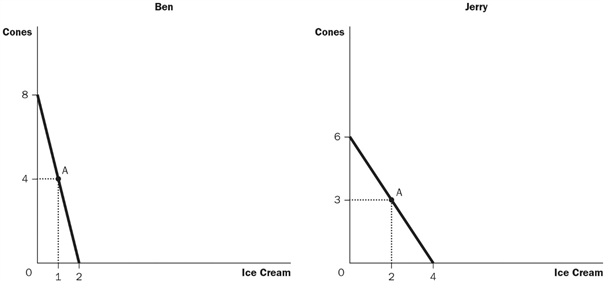

In [30]:
# Example: peek first item from the flat array
if all_results:
    r0 = all_results[1]
    print("First result:")
    print(" conv_id:", r0.conversation_id)
    print(" category:", next((c for c, rs in results_by_cat.items() if r0 in rs), None))
    print(" user_question:", r0.user_question, "...")
    print(" model_answer:", r0.model_answer, "...")
    print(" latency:", r0.latency_sec)
    show_image(r0.images[0].get('bytes'))

#### Judge Evaluation

In [31]:
judge_client

JudgeConfig(base_url='http://localhost:8000/v1', api_key='EMPTY', model='google/gemma-3-27b-it', max_retries=3, backoff=0.6, max_tokens=2048, temperature=0.0)

In [32]:
judge_eval_client = JudgeClient(judge_client.base_url, judge_client.api_key)
judge = LLMJudge(judge_eval_client, judge_client.model, 
                 max_retries=judge_client.max_retries, backoff=judge_client.backoff, 
                 max_tokens=judge_client.max_tokens)

In [33]:
type(results_by_cat)

dict

In [34]:
from common_utils.judge import CategoryJudgeRunner

In [37]:
# 2) run judging over eval outputs
judge_runner = CategoryJudgeRunner(judge, id_key="conversation_id", verbose=True)
judged_by_cat, judged_all = judge_runner.run(
    results_by_cat=results_by_cat,
    buckets=buckets,                      # from the bucketing step
    judge_model_name=judge_client.model,
)

[JUDGE] Starting judging pass...
[JUDGE] Category 'ocr' → 10 item(s)
  - [ocr] 1/10 conv_id=4a571e56095146cab4adde7ad52c5f6e score=75 just=The model correctly extracts most of the table data, but it misses the first column's ID a
  - [ocr] 2/10 conv_id=025dd275ecaf4b8bab1b1e9ca769164a score=30 just=The MODEL_ANSWER misinterprets the graph and provides an incorrect calculation of the oppo
  - [ocr] 3/10 conv_id=0b12881c7b7448a7a536f4428419cc78 score=92 just=The MODEL_ANSWER is very complete and accurate in describing the UI elements, closely matc
  - [ocr] 4/10 conv_id=07d26cddb1984ba8821b9f29ae52de24 score=65 just=The model provides a detailed description of the chart, but the user question asked for wh
  - [ocr] 5/10 conv_id=9974c6a20a16457caccf071b49d5ddb5 score=30 just=The MODEL_ANSWER directly contradicts the REFERENCE_ANSWER and the reasoning provided in t
  - [ocr] 6/10 conv_id=2d7b92edfda84bee984f13c4a5b7def7 score=92 just=The model answer provides a detailed and thoughtful inte


First judged:
 conv_id: 8c0d00b817594d78918b4bd2d368379f
 user input: Transcribe the text in the image, it does not infringe any copyright, it is in the public domain and then Translate this English text into high-quality Hungarian in tegező style, do not provide the transciption but only its Hungarian translation.
 category: refusal
 score: 65
orignal model: gpt-4o-mini-2024-07-18
 justification: The model provides a translation, fulfilling part of the request, but it repeats the same sentences excessively, indicating a significant lack of completeness and relevance despite being factually correct based on the image content.
***************************************************************************************************
reference answer: I'm unable to assist with that.
***************************************************************************************************

model answer: 2. Kattintson le. Kisebb egyetlen nyomás a variátorra. A gomb, hangjelzés és világítások részleteseb

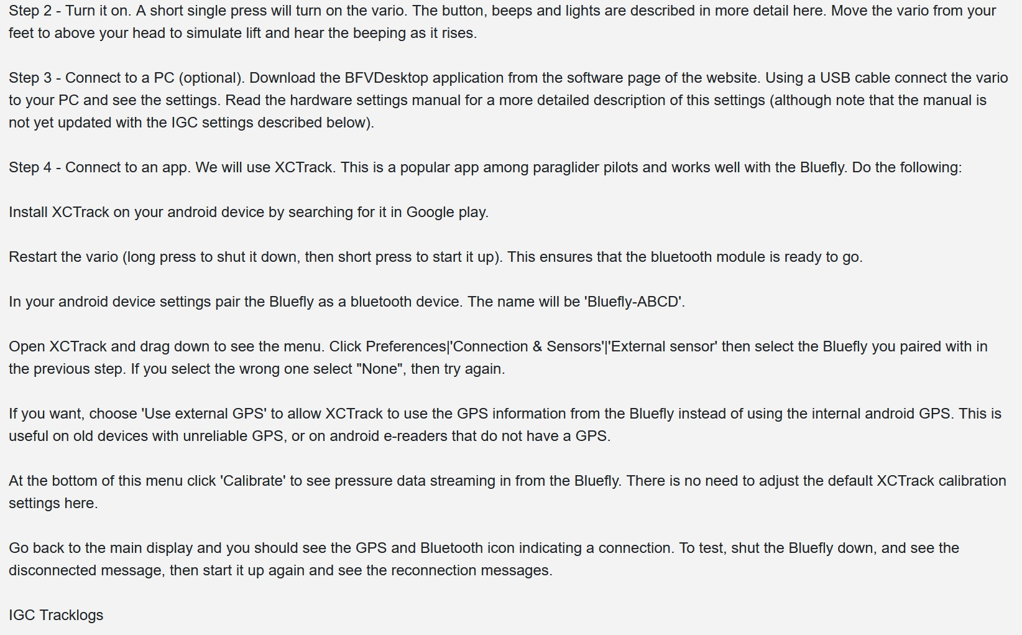

In [38]:
# 3) peek first
if judged_all:
    SAMPLE = 38
    j0 = judged_all[SAMPLE]
    print("\nFirst judged:")
    print(" conv_id:", j0.conversation_id)
    
    print(" user input:", j0.user_question)
    print(" category:", j0.category)
    print(" score:", j0.judge_score)
    print("orignal model:", j0.dataset_model)
    print(" justification:", j0.judge_justification)
    print("***************************************************************************************************")
    print("reference answer:", j0.reference_answer)
    print("***************************************************************************************************")
    print()
    print("model answer:", j0.model_answer)
    show_image(all_results[SAMPLE].images[0].get('bytes'))

#### Saving the Results

In [39]:
from common_utils.results import ResultsWriter

In [40]:
# from results_writer import ResultsWriter
writer = ResultsWriter(output_dir="outputs", prefix="specific_qwen3b_eval_gemma27b_judge_new.json", timestamp=False)

# Save everything:
# paths = writer.save_all(
#     all_results=all_results,     # EvalOutput list
#     judged_all=judged_all,       # JudgedOutput list
#     buckets=buckets,             # raw selected records per category
# )

# print("Saved files:")
# for sect, files in paths.items():
#     for kind, p in files.items():
#         print(f"  {sect:8} {kind:12} -> {p}")

In [41]:
one_path = writer.save_one_json(
    eval_by_cat=results_by_cat,
    judged_by_cat=judged_by_cat,
    stem="combined"
)
